# <span style="color:#DC143C">NCF(Neural Collaborative Filtering) 구현하기</span>
* 교수님 코드 NCF 단일 모델에 대한 참고본입니다.

* 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. 공통 설정 및 라이브러리 Imports

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score # 성능 평가
import sys
import warnings; warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed=42):
    """
    실행 결과의 재현성(Reproducibility)을 보장하기 위해 난수 시드를 고정합니다.
    시드를 고정하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)
    # 2. NumPy 시드 고정
    np.random.seed(seed)
    # 3. PyTorch CPU 연산 시드 고정
    torch.manual_seed(seed)
    # 4. CUDA (GPU) 사용 시 추가 시드 고정 및 설정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # cuDNN 관련 설정으로, GPU 연산의 비결정성을 줄여줍니다.
        # 연산 속도가 다소 느려질 수 있지만, 재현성을 높여줍니다.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 전역적으로 시드 고정 (재현성 확보)
SEED = 42
set_seed(SEED)

# 학습/추론에 사용할 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [4]:
# ====== 하이퍼파라미터 및 변수 설정 ======

# --- NCF 모델 구조 관련 ---
GMF_DIM = 8            # GMF(Generalized Matrix Factorization) 임베딩 차원
                       # 논문 권장: 8 (작을수록 계산 효율적, 클수록 표현력 증가)

MLP_DIM = 8           # MLP(Multi-Layer Perceptron) 임베딩 차원
                       # 논문 권장: GMF_DIM의 2~4배 (MLP가 더 복잡한 패턴을 학습하므로)
                       # GMF는 선형적 상호작용, MLP는 비선형적 상호작용을 모델링

MLP_LAYERS = [64, 32, 16, 8]
                       # MLP 은닉층 구조 (점진적으로 차원을 줄이는 피라미드 구조)
                       # [64, 32, 16, 8]: 첫 층은 2*MLP_DIM(=64), 이후 절반씩 감소
                       # 이유: 정보를 점진적으로 압축하면서 중요한 패턴을 추출
                       # 마지막 8차원은 GMF_DIM과 같게 설정하여 균형 유지

# --- 학습 관련 ---
BATCH_SIZE = 128       # 배치 크기 (메모리와 학습 안정성의 균형)
                       # 크면: 학습 안정적, 메모리 많이 사용
                       # 작으면: 학습 불안정, 메모리 적게 사용

EPOCHS = 20            # 최대 에폭 수 (Early Stopping으로 조기 종료 가능)

LR = 1e-4              # 학습률 (Learning Rate)
                       # 논문 권장: 0.001~0.003 범위
                       # 너무 크면 발산, 너무 작으면 학습 느림

DROPOUT_RATE = 0.3     # 드롭아웃 비율 (과적합 방지)
                       # 0.2 = 20%의 뉴런을 무작위로 비활성화
                       # 일반적으로 0.1~0.5 범위에서 설정

PATIENCE = 3           # Early Stopping patience
                       # 검증 손실이 개선되지 않아도 기다리는 에폭 수
                       # 너무 작으면(3-5): 조기 종료로 덜 학습될 수 있음
                       # 너무 크면(15-20): 과적합 위험 증가
                       # 추천: 데이터셋에 따라 5-10 범위에서 조정

# --- 추천 및 평가 관련 ---
TOP_K = 10             # 추천 결과 상위 K개 (일반적으로 5~20 사용)
# TEST_USERS = 100       # 테스트할 유저 수 (전체 유저 대상이 아닐 경우)
                       # 계산 시간 단축을 위해 샘플링 (실제 서비스에서는 전체 유저 대상)

### 1. 데이터 준비

In [5]:
# 학습 데이터 로드 및 기본 정보 확인

# Train, Test 데이터와 아이템 메타데이터를 리스트 형태로 저장함
#  순서: [train_df, test_df, train_item_meta, test_item_meta]
train_df, test_df, *_ = pd.read_pickle('/content/drive/MyDrive/4학기/추천시스템/실습-20251011/개인과제/book_train_test_1v3.pkl')

# 전체 데이터 기준으로 M, N 계산: 유저 ID와 아이템 ID는 0부터 시작한다고 가정
all_data = pd.concat([train_df, test_df])
M = all_data['USER'].max() + 1   # Number of users
N = all_data['ITEM'].max() + 1   # Number of items

print(f"총 유저 수 (M): {M}, 총 아이템 수 (N): {N}")

총 유저 수 (M): 9057, 총 아이템 수 (N): 26695


* 딥러닝의 학습사이즈는 배치이다.

In [6]:
# 데이터 준비: NCF Dataset 클래스 정의

class NCFDataset(Dataset):
    """
    NCF 학습을 위한 PyTorch Dataset 클래스입니다.
    데이터프레임(df)을 받아서 유저 ID, 아이템 ID, 레이팅(상호작용 여부)을 텐서로 변환합니다.
    """
    def __init__(self, df):
        # 유저 ID, 아이템 ID는 인덱스이므로 torch.long 타입으로 변환
        self.users = torch.tensor(df['USER'].values, dtype=torch.long)
        self.items = torch.tensor(df['ITEM'].values, dtype=torch.long)
        # 레이팅(0 또는 1)은 모델의 출력과 비교하기 위해 torch.float32 타입으로 변환
        self.ratings = torch.tensor(df['RATING'].values, dtype=torch.float32)

    def __len__(self):
        """데이터셋의 전체 크기를 반환합니다."""
        return len(self.ratings)

    def __getitem__(self, idx):
        """
        주어진 인덱스(idx)에 해당하는 (유저, 아이템, 레이팅) 쌍을 반환합니다.
        DataLoader가 배치(Batch) 단위로 데이터를 가져갈 때 사용됩니다.
        """
        return self.users[idx], self.items[idx], self.ratings[idx]

### 2. NCF 모델 정의

**NCF의 핵심 아이디어:**
- **GMF (Generalized Matrix Factorization)**: 전통적인 Matrix Factorization을 신경망으로 표현
  - 유저 벡터와 아이템 벡터를 **원소별 곱셈(element-wise product)**
  - 선형적인 상호작용 모델링 ("이 유저는 이 아이템과 얼마나 유사한가?")
  
- **MLP (Multi-Layer Perceptron)**: 비선형적 상호작용 학습
  - 유저 벡터와 아이템 벡터를 **연결(concatenation)**한 후 은닉층 통과
  - 복잡한 패턴 모델링 ("유저와 아이템의 잠재적 관계는?")
  
- **NeuMF**: GMF와 MLP의 출력을 결합하여 최종 예측
  - 두 모델의 장점을 모두 활용 (선형 + 비선형)

**왜 두 경로를 결합하는가?**
- GMF만 사용: 표현력 제한 (선형 관계만 포착)
- MLP만 사용: 단순 패턴 포착에 비효율적
- 결합: 단순한 패턴(GMF)과 복잡한 패턴(MLP)을 동시에 학습

In [7]:
class NCF(nn.Module):
    """
    NCF 논문의 NeuMF (Neural Matrix Factorization) 구조를 구현합니다.
    이는 GMF (Generalized Matrix Factorization)와 MLP (Multi-Layer Perceptron)의 출력을
    결합(Concatenation)하여 최종 예측을 수행하는 모델입니다.
    """
    def __init__(self, num_users, num_items, gmf_dim, mlp_dim, mlp_layers):
        super(NCF, self).__init__()

        # --- 1. GMF (Generalized Matrix Factorization) 부분 ---
        # GMF는 유저/아이템 임베딩을 원소별 곱(Element-wise Product)으로 상호작용을 모델링합니다. 잠재요인의 차원
        self.mf_user_embed = nn.Embedding(num_users, gmf_dim, sparse=False)
        self.mf_item_embed = nn.Embedding(num_items, gmf_dim, sparse=False)

        # --- 2. MLP (Multi-Layer Perceptron) 부분 ---
        # MLP는 유저/아이템 임베딩을 연결(Concatenation)하여 비선형적으로 상호작용을 모델링합니다.
        self.mlp_user_embed = nn.Embedding(num_users, mlp_dim, sparse=False)
        self.mlp_item_embed = nn.Embedding(num_items, mlp_dim, sparse=False)

        # MLP 레이어 동적 생성: 2*MLP_DIM 크기에서 시작하여 계층적으로 은닉층을 구성
        mlp_modules = []
        input_size = mlp_dim * 2 # 유저 임베딩(mlp_dim) + 아이템 임베딩(mlp_dim)
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.ReLU()) # 비선형 활성화 함수 (NCF 논문에서 사용)
            mlp_modules.append(nn.Dropout(p=DROPOUT_RATE)) # 과적합 방지
            input_size = layer_size # 다음 레이어의 입력 크기 업데이트
        self.mlp = nn.Sequential(*mlp_modules)

        # --- 3. 최종 예측 레이어 (NeuMF) ---
        # GMF 출력(gmf_dim)과 MLP 출력(mlp_layers[-1])을 연결하여 최종 예측을 수행
        final_input_size = gmf_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(final_input_size, 1) # 최종적으로 1개의 예측값(선호도) 출력

        # 모델 가중치 초기화
        self._init_weights()

    def _init_weights(self):
        """
        NCF 논문에서 권장하는 임베딩 및 선형 레이어 가중치 초기화 방식입니다.
        이는 학습 안정화 및 성능 향상에 도움을 줍니다.
        """
        # 임베딩 레이어: 평균 0, 표준편차 0.01의 정규분포로 초기화
        nn.init.normal_(self.mf_user_embed.weight, std=0.01)
        nn.init.normal_(self.mf_item_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_user_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embed.weight, std=0.01)

        # 선형 레이어: Xavier Uniform 초기화 (입력/출력 차원을 고려한 초기화)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias) # 편향(Bias)은 0으로 초기화

    def forward(self, user_indices, item_indices):
        """
        입력 유저 및 아이템 인덱스를 받아 최종 선호도 예측값(Logits)을 계산합니다.
        Forward Pass 흐름:
        1. GMF 경로: 유저/아이템 임베딩 → 원소별 곱
        2. MLP 경로: 유저/아이템 임베딩 → 연결 → 은닉층
        3. 결합: GMF + MLP 출력 연결 → 최종 예측
        """
        # --- 1. GMF 계산 ---
        mf_user = self.mf_user_embed(user_indices)
        mf_item = self.mf_item_embed(item_indices)
        gmf_output = mf_user * mf_item # 원소별 곱 (Element-wise Product)
        # 예: [0.1, 0.2] * [0.3, 0.4] = [0.03, 0.08]

        # --- 2. MLP 계산 ---
        mlp_user = self.mlp_user_embed(user_indices)
        mlp_item = self.mlp_item_embed(item_indices)
        mlp_input = torch.cat([mlp_user, mlp_item], dim=1) # 임베딩 벡터 연결 (Concatenation)
        # 예: [0.1, 0.2] + [0.3, 0.4] = [0.1, 0.2, 0.3, 0.4]
        mlp_output = self.mlp(mlp_input) # MLP 은닉층 통과

        # --- 3. NeuMF 결합 ---
        # GMF 출력과 MLP 출력을 다시 연결
        neumf_input = torch.cat([gmf_output, mlp_output], dim=1)
        # 최종 예측 레이어를 통과 (Logit 값 출력)
        logits = self.predict_layer(neumf_input).squeeze(-1)
        return logits

### 3. NCF 모델 학습

=== NCF 모델 학습 시작 ===
Epoch [1/20], Train Loss: 0.5891, Valid Loss: 0.5535
Epoch [2/20], Train Loss: 0.5484, Valid Loss: 0.5331
Epoch [3/20], Train Loss: 0.5233, Valid Loss: 0.5374
Epoch [4/20], Train Loss: 0.5102, Valid Loss: 0.5448
Epoch [5/20], Train Loss: 0.5039, Valid Loss: 0.5535
Early stopping at epoch 5 (patience=3)


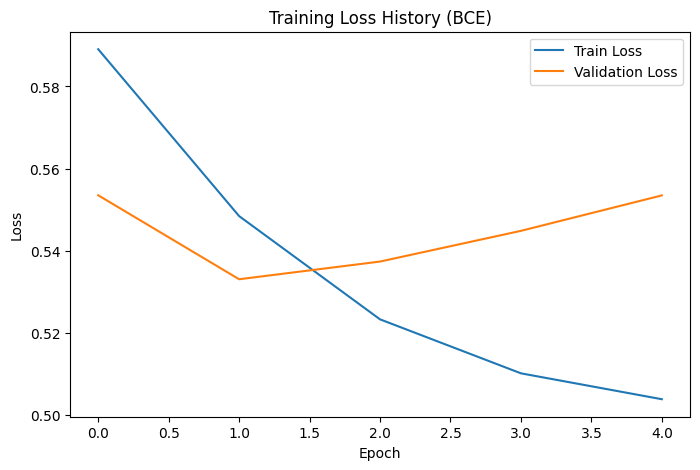

In [8]:
print("=== NCF 모델 학습 시작 ===")

# === NCF 모델 인스턴스 생성 ===
model = NCF(
    num_users=M,
    num_items=N,
    gmf_dim=GMF_DIM,
    mlp_dim=MLP_DIM,
    mlp_layers=MLP_LAYERS
).to(device)

# === 손실 함수 및 옵티마이저 설정 ===
# BCEWithLogitsLoss: Binary Cross Entropy + Sigmoid 결합
# 왜 일반 BCE가 아닌가?
# - 수치적 안정성: log(sigmoid(x))를 직접 계산하면 언더플로우 발생 가능
# - BCEWithLogitsLoss는 log-sum-exp 트릭으로 안정적 계산
criterion = nn.BCEWithLogitsLoss()

# RMSprop 옵티마이저(가중치 업데이튼) 사용
# NCF 원논문은 Adam을 권장하지만, 이 데이터셋에서는 Adam 사용 시 과적합 발생
# RMSprop은 Adam보다 일반화 성능이 좋고 검증 손실이 더 안정적
# - 적응형 학습률을 사용하지만 momentum 없이 동작
# - 추천 시스템의 sparse한 데이터에서 과적합 방지에 효과적
# weight_decay=1e-5: L2 정규화 (과적합 방지 추가)
optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-5)

model.to(device) # 모델을 지정된 디바이스(CPU/GPU)로 이동
model.train()
loss_history = []
best_val_loss = float('inf')
trigger_times = 0

# === 데이터 분할 및 재현성 확보 ===
# 학습/검증(Train/Valid) 데이터 분할: 데이터를 랜덤하게 섞어서 분할합니다.
# random_state=42를 사용하여 이 분할 과정도 재현성을 보장합니다.
train_df_shuffled = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
split_idx = int(len(train_df_shuffled) * 0.9) # 90% 학습, 10% 검증
train_data = train_df_shuffled.iloc[:split_idx]
valid_data = train_df_shuffled.iloc[split_idx:]

# DataLoader 생성: 배치 단위로 데이터를 모델에 공급
# 학습 데이터는 매 Epoch마다 셔플(shuffle=True)하여 학습 다양성을 확보합니다.
# 드롭아웃 등의 무작위성이 있지만, 전역 시드 설정으로 초기 조건이 고정되어 재현성이 보장됩니다.
train_loader = DataLoader(NCFDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(NCFDataset(valid_data), batch_size=BATCH_SIZE * 2, shuffle=False)

for epoch in range(EPOCHS):
    # --- Training Loop ---
    total_train_loss = 0
    model.train() # 모델을 학습 모드로 설정 (Dropout 활성화)
    for user_batch, item_batch, rating_batch in train_loader:
        # 데이터 디바이스 이동
        user_batch, item_batch, rating_batch = user_batch.to(device), item_batch.to(device), rating_batch.to(device)

        # 1. Forward Pass
        logits = model(user_batch, item_batch)
        # 2. Loss 계산
        loss = criterion(logits, rating_batch)

        # 3. Backward Pass & Optimizer Step
        optimizer.zero_grad() # 이전 배치의 기울기 초기화
        loss.backward()       # 역전파를 통해 기울기 계산
        optimizer.step()      # 가중치 업데이트

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation Loop ---
    model.eval() # 모델을 평가 모드로 설정 (Dropout 비활성화)
    total_val_loss = 0
    with torch.no_grad(): # 검증 시에는 기울기 계산을 하지 않아 메모리 및 속도 최적화
        for user_val, item_val, rating_val in valid_loader:
            user_val, item_val, rating_val = user_val.to(device), item_val.to(device), rating_val.to(device)

            logits_val = model(user_val, item_val)
            loss_val = criterion(logits_val, rating_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(valid_loader)

    loss_history.append({'loss': avg_train_loss, 'val_loss': avg_val_loss})

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')

    # --- Early Stopping (조기 종료) ---
    # 검증 손실이 더 이상 개선되지 않으면 학습을 조기 종료하여 과적합을 방지합니다.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1} (patience={PATIENCE})")
            break

# 손실 곡선 시각화
plt.figure(figsize=(8, 5))
plt.plot([h['loss'] for h in loss_history], label="Train Loss")
plt.plot([h['val_loss'] for h in loss_history], label="Validation Loss")
plt.title("Training Loss History (BCE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 4. NCF 성능 평가

In [9]:
print(f"\n=== 추천 성능 평가 ===")

# 모델을 평가 모드로 전환 (dropout, batch normalization 등이 비활성화됨)
model.eval()

# 각 지표를 저장할 리스트 초기화
recalls, precisions, ndcgs = [], [], []

# 테스트 데이터의 모든 사용자에 대해 반복
for user_id in test_df['USER'].unique():

    # === Ground Truth 준비 ===
    # 해당 사용자가 실제로 좋아한 아이템들 (RATING=1인 아이템들)을 집합으로 저장
    actual = set(test_df[test_df['USER']==user_id]['ITEM'].values)

    # 만약 사용자가 좋아하는 아이템이 하나도 없으면 평가 불가능하므로 건너뜀
    if len(actual) == 0:
        continue

    # === 모든 아이템에 대한 선호도 점수 예측 ===
    with torch.no_grad():  # 평가 시에는 gradient 계산 불필요 (메모리 절약, 속도 향상)
        # 사용자 ID를 N개(아이템 개수만큼) 복제한 텐서 생성
        # 예: user_id=5이면 [5, 5, 5, ..., 5] (N개)
        user_tensor = torch.full((N,), user_id, dtype=torch.long).to(device)

        # 모든 아이템 ID 생성 [0, 1, 2, ..., N-1]
        item_tensor = torch.arange(N, dtype=torch.long).to(device)

        # 모델을 통해 (사용자, 각 아이템) 쌍의 선호도 점수 계산
        logits = model(user_tensor, item_tensor)

        # Sigmoid 함수를 적용하여 0~1 사이의 확률값으로 변환 후 numpy 배열로 변환
        scores = torch.sigmoid(logits).cpu().numpy()

    # === Top-K 아이템 추출 ===
    # 점수가 높은 순서대로 정렬하여 상위 K개 아이템의 인덱스 추출
    # argsort: 오름차순 정렬된 인덱스 반환 → [-K:]: 뒤에서 K개 → [::-1]: 역순(내림차순)
    top_k_indices = np.argsort(scores)[-TOP_K:][::-1]

    # 추천된 상위 K개 아이템을 집합으로 변환 (교집합 연산을 위해)
    top_k_items = set(top_k_indices)

    # === Precision, Recall 계산 ===
    # 실제로 좋아하는 아이템과 추천 아이템의 교집합 개수 (적중 개수)
    hits = len(actual & top_k_items)

    # Precision@K: 추천한 K개 중 실제로 좋아하는 아이템의 비율
    precisions.append(hits / TOP_K)

    # Recall@K: 실제로 좋아하는 아이템 중 추천된 아이템의 비율
    recalls.append(hits / len(actual))

    # === NDCG (Normalized Discounted Cumulative Gain) 계산 ===
    # DCG 초기화 (순위를 고려한 누적 이득)
    dcg = 0.0

    # 추천된 각 아이템에 대해 순위별로 점수 계산
    for i, item in enumerate(top_k_indices):
        # 추천된 아이템이 실제로 좋아하는 아이템이면
        if item in actual:
            # 상위 순위일수록 높은 가중치 부여
            # log2(i+2)로 나누는 이유: i=0일 때 log2(2)=1, i=1일 때 log2(3)≈1.58...
            # 즉, 순위가 낮을수록 discount (할인) 적용
            dcg += 1.0 / np.log2(i + 2)

    # IDCG (Ideal DCG): 이상적인 경우의 DCG 값
    # 실제로 좋아하는 아이템을 모두 상위 순위에 추천했을 때의 최대 DCG
    # min(len(actual), K): 좋아하는 아이템이 K개보다 적을 수 있으므로
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual), TOP_K))])

    # NDCG: DCG를 IDCG로 정규화 (0~1 사이 값, 1에 가까울수록 좋음)
    # IDCG가 0이면 (좋아하는 아이템이 없으면) NDCG도 0
    ndcg = dcg / idcg if idcg > 0 else 0.0
    ndcgs.append(ndcg)

# === 최종 결과 출력 ===
# 모든 테스트 사용자에 대한 평균 지표 출력
print(f"Precision@{TOP_K}: {np.mean(precisions):.4f}")  # 정확도
print(f"Recall@{TOP_K}:    {np.mean(recalls):.4f}")     # 재현율
print(f"NDCG@{TOP_K}:      {np.mean(ndcgs):.4f}")       # 순위 고려 정확도


=== 추천 성능 평가 ===
Precision@10: 0.0124
Recall@10:    0.0298
NDCG@10:      0.0238


# <span style="color:#DC143C">End</span>